In [1]:
%load_ext autoreload
%autoreload 2
from analysis_settings import *
from plot_settings import *
from os.path import join
import pandas as pd
import seaborn as sns
from scripts.utils_plot import (explode_df, plot_psd_df, _save_fig, _add_band,
                                _add_band_annotations,
                                _get_sample_sizes)
import scripts.config as cfg
from matplotlib.ticker import ScalarFormatter
import numpy as np
from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox

In [2]:
sns.set_style('darkgrid')
ch_choice = 'ch_dist_sweet'
dataframes = get_dfs(ch_choice)

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

In [3]:
# df = dataframes['df_norm']  # find representative subject
# kind = 'normalized'
# # make new column which concatenates subject and ch_nme
# df['subject_ch'] = df.subject + '_' + df.ch_nme

# # filter df
# mask = (df.cond == 'offon_abs')
# reduced_beta_low = df[mask & (df.beta_low_abs_max > 0)].subject_ch
# reduced_beta_high = df[mask & (df.beta_high_abs_max > 0)].subject_ch
# low_beta_reduction_stronger_than_high = df[mask & (df.beta_low_abs_max > df.beta_high_abs_max)].subject_ch
# enhanced_theta = df[mask & (df.theta_abs_max < 0)].subject_ch
# enhanced_low_gamma = df[mask & (df.gamma_low_abs_max < 0)].subject_ch

# mask = (df.subject_ch.isin(reduced_beta_low)
#         # & df.subject_ch.isin(reduced_beta_high)
#         # & df.subject_ch.isin(low_beta_reduction_stronger_than_high)
#         # & df.subject_ch.isin(enhanced_theta)
#         # & df.subject_ch.isin(enhanced_low_gamma)
#         )
# df_filt = df[mask & (df.cond.isin(['off', 'on']))]
# # for each subject and channel plot off and on spectrum

# fm_params = False if kind == 'normalized' else 'broad'
# for subject_ch in df_filt.subject_ch.unique():
#     df_subj = df_filt[df_filt.subject_ch == subject_ch]

#     df_freqs = explode_df(df_subj, psd='psd', fm_params=fm_params)
#     if df_freqs.empty:
#         continue
#     save_name = join("exemplary_psds", subject_ch)
#     ylim = df_freqs[df_freqs.psd_freqs > 1].psd.max()
#     plot_psd_df(df_freqs, psd='psd', save_name=save_name,
#                 save_dir=join('..', '..', cfg.FIG_RESULTS),
#                 xlim=(0, 45), ci=None, ylim=None,
#                 title=subject_ch,
#                 # bands=['delta', 'theta', 'alpha', 'beta_low', 'beta_high', 'gamma_low'],
#                 bands=BANDS,
#                 xscale="linear", yscale="log", hue_order=['off', 'on'],
#                 **{'height': 2, 'aspect': 1}, show=True,
#                 palette=[cfg.COLOR_OFF, cfg.COLOR_ON])


#     break

In [4]:

def representative_spectrum(df, kind, save_dir=None,
                            use_peak_power=False, height=1.5, aspect=1,
                            xscale="linear", yscale="log", ylabel=None,
                            legend=True, ylim=None, sub_hemis=['NeuEL031_R']):
    """Find a nice exemplary power spectrum for paper and talk.

    Should fulfill in ON condition:
    - enhanced theta
    - strongly reduced low beta
    - slightly reduced high beta
    - beta OFF-ON somewhat different in normalized and absolute
    """
    fm_params = False if kind == 'normalized' else 'broad'
    df = df[df.cond.isin(['off', 'on']) & (df.project != 'all')]
    pwr = 'max' if use_peak_power else 'mean'
    pwr_cols = [f'{band}_abs_{pwr}' for band in BANDS]
    pwr_cols += [f'{band}_fm_mean' for band in BANDS]
    pwr_cols += [f'{band}_fm_band_aperiodic_log' for band in BANDS]
    freq_cols = [f'{band}_abs_max_freq' for band in BANDS]
    keep_cols = ['fm_freqs', 'fm_psd_ap_fit', 'fm_psd_peak_fit',
                 'fm_offset', 'fm_exponent'] + pwr_cols + freq_cols
    normalization_range = (5, 95)
    if xscale == 'log':
        xlim = (1, 100) if kind == 'periodic' else normalization_range
        if kind == 'normalized':
            ylim = None
        elif kind == 'absolute':
            # ylim = (0.0007, 2)
            ylim = (0.007, 3)
        elif kind == 'periodic':
            ylim = (0.007, 5)
        # ylim = (0.008, 1.3) if kind == 'absolute' else None
    else:
        xmin = cfg.BANDS[BANDS[0]][0]  # otherwise delta band is cut off
        xmax = XTICKS_FREQ_low[-1]  # ok to cut off low gamma
        # xmax = 40  # ok to cut off low gamma
        xlim = (xmin, xmax)
        # ylim = (0, 12) if kind == 'normalized' else (0, 1.3)
        if kind == 'normalized':
            ylim = (0, 10)
        elif kind == 'absolute':
            ylim = (0, 1.3)
        elif kind == 'periodic':
            ylim = (0, 1.3)
    for sub_hemi in sub_hemis:
        fname = f'{kind}_{sub_hemi}'
        df_filt = df[(df.sub_hemi == sub_hemi)]
        if len(df_filt) < 2:
            continue  # both conditions must be present
        if xscale == 'log':
            if kind == 'periodic':
                assert df_filt.fm_fit_range.nunique() == 1
                fit_range = df_filt.fm_fit_range.unique()[0]
                xticks = fit_range
            else:
                xticks = normalization_range
        else:
            xticks = XTICKS_FREQ_low

        df_filt = explode_df(df_filt, psd='psd', fm_params=fm_params,
                             keep_cols=keep_cols)
        fpath = join(save_dir, fname + '_' + xscale)
        plot_psd_df_annotated(df_filt, psd='psd', save_name=fpath,
                              use_peak_power=use_peak_power,
                    # xlim=(4, xlim[1]),
                    xlim=xlim,
                    ylim=ylim,
                    # ylim=None,
                    ylabel=ylabel,
                    xscale=xscale, yscale=yscale, legend=legend,
                    bands=BANDS, xticks=xticks, kind=kind,
                    **{'height': height, 'aspect': aspect})


def plot_psd_df_annotated(df, freqs="psd_freqs", psd="asd", hue="cond",
                          xscale="log", yscale="log",
                          use_peak_power=False,
                          bands=None, ylabel=None, xlim=None,
                          ylim=None, ax_kwargs={}, kind=None,
                          save_name=None, col=None, legend=True, xticks=None,
                          col_order=None, row=None, add_band_colors=False,
                          **rel_kwargs):
    if ylabel is None:
        if kind in ['absolute', 'periodic']:
            ylabel = r"PSD [$\mu V^2/Hz$]"
        else:
            ylabel = "Normalized PSD [%]"
    if xlim:
        xmask = ((df[freqs] >= xlim[0]) & (df[freqs] <= xlim[1]))
        df = df.loc[xmask]
    # project = df.project.unique()[0]
    global c_off, c_on
    if kind == 'normalized':
        c_off = cfg.COLOR_DIC['all']
        c_on = cfg.COLOR_DIC['all2']
    elif kind == 'absolute':
        c_off = cfg.COLOR_DIC[kind]
        c_on = cfg.COLOR_DIC[kind + '2']
    elif kind in ['periodic', 'lorentzian']:
        c_off = cfg.COLOR_DIC['all']
        c_on = cfg.COLOR_DIC['all2']
    # c_off = cfg.COLOR_DIC[project]
    # c_on = cfg.COLOR_DIC[project + '2']
    if kind == 'periodic' and xscale == 'linear':
        hue_order = ['on', 'off']
        palette = [c_on, c_off]
    else:
        hue_order = ['off', 'on']
        palette = [c_off, c_on]
    g = sns.relplot(data=df, x=freqs, y=psd, hue=hue, hue_order=hue_order,
                    kind="line", palette=palette, col=col, col_order=col_order,
                    row=row, **rel_kwargs, zorder=5)
    ax = g.axes[0, 0]
    g._legend.remove()
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        labels = [cfg.COND_DICT[l] for l in labels]
        ax.legend(handles, labels, title='Levodopa', loc='upper right',
                  handlelength=1)

    assert len(g.axes) == 1, "Only one ax supported"
    if xscale == "log":
        ax.get_xaxis().set_major_formatter(ScalarFormatter())
        ax.get_xaxis().set_tick_params(which='minor', size=0)
        xticklabels = [f"{x} Hz" for x in xticks]
        # Add frequency bands
        for xtick in XTICKS_FREQ_low:
            ax.axvline(x=xtick, color='w', lw=LINEWIDTH_AXES)
        # xlabel = "Frequency [Hz] (log. scale)"
        # title = "Double logarithmic"
        # title = "Log-log"
    else:
        xticklabels = XTICKS_FREQ_low_labels
        # xlabel = "Frequency [Hz] (linear scale)"
        # title = "Linear"
    xlabel = "Frequency [Hz]"
    add_integral_str(df, freqs, psd, ax, kind, xscale, c_off, c_on)
    g.set(xscale=xscale, yscale=yscale, **ax_kwargs,
          xticks=xticks, xticklabels=xticklabels,
        #   title=title,
          ylabel=ylabel, xlabel=xlabel, ylim=ylim, xlim=xlim)
    annotate_peaks(df, ax, xscale, kind, use_peak_power=use_peak_power)
    if add_band_colors:
        _add_band(bands, g)
    if (xscale == 'linear'):
        _add_band_annotations(bands, g)
    else:
        if (kind == 'periodic'):
            _add_band_annotations(bands, g, short=True)
        else:
            _add_band_annotations(bands[1:], g, short=True)
    plt.tight_layout()
    _save_fig(g, save_name, SAVE_DIR, transparent=False, close=False,
              bbox_inches=None)
    plt.show()


def annotate_peaks(df, ax, xscale, kind, annotate_center_frequency=False,
                   use_peak_power=False):
    # textcolor = 'dimgrey'
    textcolor = '#262626'
    text_box = dict(
        # facecolor='whitesmoke',
        # facecolor='w',
        facecolor='#eaeaf2',
                    pad=.4, boxstyle='round',
                    # edgecolor='None'
                    edgecolor='#cccccc'
                    )
    z_front = 6
    # z_back = 0
    z_back_middle = 2
    dotted_line = dict(color=textcolor, lw=LINEWIDTH_AXES, ls=':',
                       zorder=z_front)
    text_kwargs = dict(bbox=text_box, color=textcolor, va='center')
    if xscale == 'log':
        if kind in ['normalized', 'absolute']:
            xmin, xmax = ax.get_xlim()
            log_center = 10**((np.log10(xmin) + np.log10(xmax)) / 2 )
            ax.set_xticks([log_center], minor=True)
            ax.set_xticklabels([r'$-$ Normalization Range $-$'], minor=True,
                                y=-.02, color=textcolor)
        elif kind == 'periodic':
            _annotate_log_periodic(df, ax, textcolor, text_box, z_front,
                                   dotted_line)
    elif xscale == 'linear':
        arrow_range=dict(facecolor=textcolor, shrinkA=0, shrinkB=0,
                         arrowstyle='|-|', mutation_scale=1,
                         edgecolor=textcolor)
        if kind == 'normalized':
            # if annotate_center_frequency:
            #     _annotate_lin_norm(df, ax, textcolor, text_box, dotted_line,
            #                     arrow_range)
            _annotate_norm_and_abs(df, ax, kind, textcolor, z_front, dotted_line,
                               text_kwargs, arrow_range,
                               ['beta_low'],
                               use_peak_power=use_peak_power)
        elif kind == 'absolute':
            _annotate_norm_and_abs(df, ax, kind, textcolor, z_front, dotted_line,
                               text_kwargs, arrow_range, ['beta_low'])
        elif kind == 'periodic':
            _annotate_lin_per(df, ax, textcolor, z_front, z_back_middle,
                              text_kwargs, use_peak_power=True)

        # if kind in ['normalized', 'absolute']:
        #     _annotate_norm_abs(df, ax, kind, textcolor, z_front, dotted_line,
        #                        text_kwargs, arrow_range)


def _annotate_norm_and_abs(df, ax, kind, textcolor, z_front, dotted_line,
                       text_kwargs, arrow_range, bands,
                       use_peak_power=False):
    # Extract peak points
    if use_peak_power:
        pwr = 'max'
        pwr_str = 'Total'
    else:
        pwr = 'mean'
        pwr_str = 'Mean'
    for band in bands:
        peak_power_off = df[df.cond == 'off'][f'{band}_abs_{pwr}'].values[0]
        peak_power_on = df[df.cond == 'on'][f'{band}_abs_{pwr}'].values[0]
        if use_peak_power:
            peak_freq_off = df[df.cond == 'off'][f'{band}_abs_max_freq'].values[0]
            peak_freq_on = df[df.cond == 'on'][f'{band}_abs_max_freq'].values[0]
        else:
            band_borders = cfg.BANDS[band]
            peak_freq_off = peak_freq_on = band_borders[-1]
        x_center = (peak_freq_off + peak_freq_on) / 2
        y_center = (peak_power_off + peak_power_on) / 2

        # Indicate Peaks as points
        if use_peak_power:
            peak_points = dict(marker='o', markersize=.2, c=textcolor,
                            zorder=z_front)
            ax.plot(peak_freq_off, peak_power_off, **peak_points)
            ax.plot(peak_freq_on, peak_power_on, **peak_points)

        # Annotate power

        # Text
        units = '\n'r'$\mu V^2/Hz$' if kind == 'absolute' else '%'
        if band == 'beta_low':
            power_diff_str = f'\n= {peak_power_off - peak_power_on:.1f}{units}'
            # pwr_str = f'Total\n{cfg.BAND_NAMES_GREEK[band]}\nPower\noff-on'
            pwr_str = f'{pwr_str}\n{cfg.BAND_NAMES_GREEK[band]}\npower\noff-on' + power_diff_str
            # _add_xspace = 1 if kind == 'absolute' else 0
            # x_text_pwr = x_center + 20 + _add_xspace
            x_text_pwr = 34
            ax.annotate(pwr_str, xy=(x_center, y_center),
                        xytext=(x_text_pwr, y_center), ha='left',
                        **text_kwargs)
            # Vertical bracket
            # x_arrow_pwr = x_center + 18 + _add_xspace
            x_arrow_pwr = 32
            ax.annotate('', xy=(x_arrow_pwr, peak_power_off),
                        xytext=(x_arrow_pwr, peak_power_on), arrowprops=arrow_range)
            # Dashed lines
            ax.hlines(peak_power_off, peak_freq_off, x_arrow_pwr, **dotted_line)
            ax.hlines(peak_power_on, peak_freq_on, x_arrow_pwr, **dotted_line)
            # Mean power line
            if not use_peak_power:
                ax.hlines(peak_power_off, *band_borders,
                          color=c_off,
                          lw=LINEWIDTH_AXES)
                ax.hlines(peak_power_on, *band_borders,
                          color=c_on,
                          lw=LINEWIDTH_AXES)


def _annotate_lin_per(df, ax, textcolor, z_front, z_back_middle, text_kwargs,
                      use_peak_power=False):
    band = 'beta_low'
    cond = 'off'
    df_cond = df[df.cond == cond]
    c_str = df.project.unique()[0]
    c_str += '2' if cond == 'on' else ''
    # color_cond = cfg.COLOR_DIC[c_str]

    fm_freqs = df_cond.fm_freqs.iloc[0]
    ap_fit = df_cond.fm_psd_ap_fit.iloc[0]
    per_fit = df_cond.fm_psd_peak_fit.iloc[0]

    # # Gaussian params
    # amp = df_cond.fm_powers.iloc[0][2]
    # std = df_cond.fm_standard_devs.iloc[0][2]
    # cf = df_cond.fm_center_freqs.iloc[0][2]

    # Plot 1/f exponent
    c_ap = cfg.COLOR_DIC['periodicAP']
    ax.plot(fm_freqs, ap_fit, c=c_ap, ls="--",
            label="Aperiodic fit", zorder=z_front)
    # Plot periodic fit
    c_per = cfg.COLOR_DIC['periodic']
    ax.plot(fm_freqs, ap_fit + per_fit, c=c_per, ls="--",
            zorder=z_front, label="Periodic fit")

    # Total power
    x_text = 32  # Hz
    peak_freq = df_cond[f'{band}_abs_max_freq'].values[0]
    if use_peak_power:
        x_arrow = peak_freq
    else:
        band_borders = cfg.BANDS[band]
        x_arrow = band_borders[1]

    freq_mask = (fm_freqs == peak_freq)
    arr_pwr = dict(facecolor=textcolor, shrinkA=0, shrinkB=1.5,
                   edgecolor=textcolor, arrowstyle='-|>',
                mutation_scale=3)
    arr_kwargs = dict(arrowprops=arr_pwr, zorder=z_back_middle)
    if use_peak_power:
        total_pwr = ap_fit[freq_mask] + per_fit[freq_mask]
    else:
        total_pwr = df_cond[f'{band}_abs_mean'].values[0]
        ax.hlines(total_pwr, *band_borders, color=c_off, lw=LINEWIDTH_AXES)
    ax.annotate('', xy=(x_arrow, total_pwr), xytext=(x_text, total_pwr),
                **arr_kwargs)
    text_kwargs_tot = text_kwargs.copy()
    text_kwargs_tot['color'] = 'k'
    ax.text(s='Total\npower', x=x_text, y=total_pwr, **text_kwargs_tot)

    # Periodic power
    if use_peak_power:
        height_ap = ap_fit[freq_mask] / 2
        y_text_ap = height_ap * 6
        y_periodic = (total_pwr + y_text_ap) / 2
        y_text_per = y_periodic
    else:
        height_ap = 10**df_cond[f'{band}_fm_band_aperiodic_log'].values[0]
        y_periodic = df_cond[f'{band}_fm_mean'].values[0]
        ax.hlines(y_periodic, *band_borders, color=c_per, lw=LINEWIDTH_AXES)
        ax.hlines(height_ap, *band_borders, color=c_ap, lw=LINEWIDTH_AXES)
        y_text_ap = height_ap * 2
        y_text_per = y_periodic * .84
    text_kwargs_per = text_kwargs.copy()
    text_kwargs_per['color'] = c_per
    ax.text(s='Periodic\npower', x=x_text, y=y_text_per, **text_kwargs_per)
    ax.annotate("", xy=(x_arrow, y_periodic), xytext=(x_text, y_periodic),
                **arr_kwargs)
    ax.vlines(peak_freq, ap_fit[freq_mask], total_pwr, color=c_per)

    # Aperiodic power
    text_kwargs_ap = text_kwargs.copy()
    text_kwargs_ap['color'] = c_ap
    ax.annotate('Aperiodic\npower', xytext=(x_text, y_text_ap),
                xy=(x_arrow, height_ap), **text_kwargs_ap, **arr_kwargs)
    ax.vlines(peak_freq, 0, ap_fit[freq_mask], color=c_ap, lw=1.5)


# def _annotate_lin_norm(df, ax, textcolor, text_box, dotted_line, arrow_range):
#     # Extract peak points
#     # band = 'beta_low'
#     band = 'beta_high'
#     peak_power_off = df[df.cond == 'off'][f'{band}_abs_max'].values[0]
#     peak_power_on = df[df.cond == 'on'][f'{band}_abs_max'].values[0]
#     peak_freq_off = df[df.cond == 'off'][f'{band}_abs_max_freq'].values[0]
#     peak_freq_on = df[df.cond == 'on'][f'{band}_abs_max_freq'].values[0]

#     # Annotate frequencies
#     # Text
#     freq_diff = peak_freq_off - peak_freq_on
#     # freq_str = cfg.BAND_NAMES_GREEK[band] + f'\nFreq.\noff-on'
#     freq_diff_str = f' Frequency\noff-on = {freq_diff:.0f} Hz'
#     freq_str = cfg.BAND_NAMES_GREEK[band] + freq_diff_str
#     y_top = max(peak_power_off, peak_power_on)
#     y_text_freq = y_top * 1.7
#     ax.annotate(freq_str, xy=(peak_freq_off, y_top),
#                 bbox=text_box, color=textcolor,
#                 xytext=(peak_freq_off - 5, y_text_freq), va='center',
#                 ha='left')
#                 # ha='center')
#     # Arrow
#     y_arrow_freq = y_text_freq * .85
#     ax.annotate('', xy=(peak_freq_off, y_arrow_freq),
#                 xytext=(peak_freq_on, y_arrow_freq),
#                 arrowprops=arrow_range)
#     # Dashed lines
#     # ax.vlines(peak_freq_on, peak_power_off, peak_power_on, **dotted_line)
#     ax.vlines(peak_freq_on, y_arrow_freq, peak_power_on, **dotted_line)
#     ax.vlines(peak_freq_off, y_arrow_freq, peak_power_off, **dotted_line)

#     # xy_off = (peak_freq_off, peak_power_off)
#     # xy_on = (peak_freq_on, peak_power_on)
#     # xytext = (peak_freq_off, peak_power_off * 1.25)
#     # band_str = cfg.BAND_NAMES_GREEK[band] + ' Power'
#     # ax.annotate(band_str, xy=xytext, xycoords='data',
#     #             ha='center', va='center')
#     # ax.annotate('', xy=xy_off, xycoords='data', xytext=xytext,
#     #             ha='center', va='center', arrowprops=arrowprops)
#     # ax.annotate('', xy=xy_on, xycoords='data', xytext=xytext, zorder=10000,
#     #             ha='center', va='center', arrowprops=arrowprops)

#     # # Annotate vertical line indicating power off-on difference
#     # ax.vlines(x_center, peak_power_off, peak_power_on, color='k',
#     #           lw=LINEWIDTH_AXES)
#     # # horizontal lines connecting peaks from vertical line
#     # ax.hlines(peak_power_off, peak_freq_off, x_center, color='k',
#     #           lw=LINEWIDTH_AXES)
#     # ax.hlines(peak_power_on, peak_freq_on, x_center, color='k',
#     #             lw=LINEWIDTH_AXES)


def _annotate_log_periodic(df, ax, textcolor, text_box, z_front, dotted_line):
    # cond = 'on'
    # for cond in ['off', 'on']:
    for cond in ['off']:
        df_cond = df[df.cond == cond]
        c_str = df.project.unique()[0]
        c_str += '2' if cond == 'on' else ''
        # color_cond = cfg.COLOR_DIC[c_str]

        fm_freqs = df_cond.fm_freqs.iloc[0]
        ap_fit = df_cond.fm_psd_ap_fit.iloc[0]

        # Plot 1/f exponent
        c_ap = cfg.COLOR_DIC['periodicAP']
        ax.plot(fm_freqs, ap_fit, c=c_ap, ls="--", zorder=z_front,
                label="Aperiodic fit")

        # Interpolate offset
        offset = df_cond.fm_offset.unique()[0]
        exponent = df_cond.fm_exponent.unique()[0]
        x = np.arange(1, fm_freqs[0] + 1)
        ax.plot(x, offset * 1/ x**exponent, c=c_ap, ls=":",
                zorder=z_front)

        # 1/f Offset
        arr_offset = dict(facecolor=textcolor, shrinkA=0, shrinkB=1.5,
                            edgecolor=textcolor, arrowstyle='-|>',
                            mutation_scale=3)
        kwargs_text = dict(bbox=text_box, color=textcolor,
                            va='center', ha='left')
        ax.annotate('Offset',
                    xy=(x[0], offset),
                    xytext=(2.5, offset),
                    arrowprops=arr_offset, **kwargs_text)

        # 1/f Exponent
        freq_exp = (22 + 14) / 2
        arr_exponent = arr_offset.copy()
        arr_exponent.update(dict(shrinkA=.5, shrinkB=.5))
        ax.annotate('1/f Exponent',
                    xy=(14, ap_fit[fm_freqs == 22]),
                    xytext=(2.5, ap_fit[fm_freqs == 35]),
                    arrowprops=arr_exponent, **kwargs_text)
        ax.hlines(ap_fit[fm_freqs == 22], 14, 22, **dotted_line)
        ax.vlines(14, ap_fit[fm_freqs == 14], ap_fit[fm_freqs == 22],
                    **dotted_line)
        kwargs_text2 = dict(fontsize=FONTSIZE_S-2, color=textcolor)
        ax.text(14, ap_fit[fm_freqs == 20], r'$\Delta y$',
                **kwargs_text2, va='center', ha='right')
        ax.text(freq_exp, ap_fit[fm_freqs == 23], r'$\Delta x$',
                **kwargs_text2, va='top', ha='center',)

        # Fit range
        fit_low, fit_high = fm_freqs[0], fm_freqs[-1]
        log_center = 10**((np.log10(fit_low) + np.log10(fit_high)) / 2 )
        ax.set_xticks([log_center], minor=True)
        ax.set_xticklabels([r'$-$   Fit Range  $-$'], minor=True, y=-.02,
                            color='grey')

        # Dashed fit border lines
        ymin, _ = ax.get_ylim()
        ax.vlines(fit_low, ymin, ap_fit[0], **dotted_line)
        ax.vlines(fit_high, ymin, ap_fit[-1], **dotted_line)
    return


def add_integral_str(df, freqs, psd, ax, kind, xscale, c_off, c_on):
    if xscale == 'linear':
        return None
    if kind == 'periodic':
        return None
    freq_mask = ((df[freqs] >= 5) & (df[freqs] <= 95))
    units = '%' if kind == 'normalized' else r' $\mu V^2$'
    int_off = df[(df.cond == 'off') & freq_mask][psd].sum()
    int_on = df[(df.cond == 'on') & freq_mask][psd].sum()
    off_str = r'\text{PSD}_{\text{off}}=$'
    on_str = r'\text{PSD}_{\text{on}}=$'
    int_str = r'$\int_{5\text{ Hz}}^{95\text{ Hz}}'
    int_str_off = int_str + off_str
    int_str_on = int_str + on_str
    if kind == 'normalized':
        int_off_res = f'{int_off:.0f}{units}'
        int_on_res = f'{int_on:.0f}{units}'
    else:
        int_off_res = f'{int_off:.1f}{units}'
        int_on_res = f'{int_on:.1f}{units}'
    int_off = int_str_off + int_off_res
    int_on = int_str_on + int_on_res
    # project = df.project.unique()[0]
    # c_off = cfg.COLOR_DIC[project]
    # c_on = cfg.COLOR_DIC[project + '2']
    if kind == 'normalized':
        pos1 = (.03, .045)
        pos2 = (0, 0)
        fs = FONTSIZE_S
        pad = 0
        sep = 3
    elif kind == 'absolute':
        pos1 = (.96, .95)
        pos2 = (1, 1)
        fs = FONTSIZE_S - 1
        pad = -1
        sep = 1.5
    texts = [TextArea(int_off, textprops=dict(color=c_off, fontsize=fs)),
            TextArea(int_on, textprops=dict(color=c_on, fontsize=fs))]
    texts_vbox = VPacker(children=texts, pad=pad, sep=sep)
    ann = AnnotationBbox(texts_vbox,
                         pos1,
                         xycoords=ax.transAxes,
                         box_alignment=pos2,
                         bboxprops=dict(
                            #  facecolor='white',
                             facecolor='#eaeaf2',
                             boxstyle='round',
                                        # edgecolor=None
                                        edgecolor='#cccccc'
                                        ))
    ax.add_artist(ann)

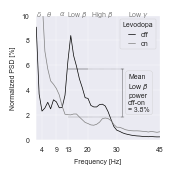

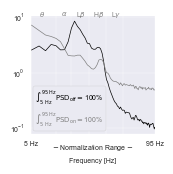

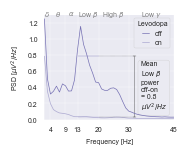

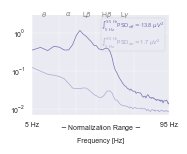

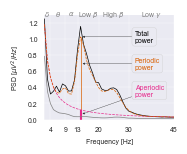

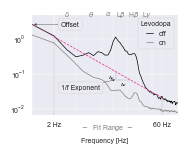

In [5]:
# sub_hemis = df_plot.sub_hemi.unique()
# sub_hemis = [
#             #  'FloML022_R', 'FloML017_L',
#                 # 'HirML002_R',
#                 # 'NeuEL006_R',
#                 # 'NeuEL011_L',
#                 # 'NeuEL025_L',
#                 'NeuEL031_R']
# for sub_hemi in sub_hemis:
#     print(sub_hemi)
for kind in ['normalized', 'absolute', 'periodic']:
# for kind in ['normalized']:
    if kind == 'normalized':
        df_plot = dataframes['df_norm']
    elif kind in ['absolute', 'periodic']:
        df_plot = dataframes['df_abs']

    if kind in ['normalized']:
        legend1 = True
        legend2 = False
        height = 1.7
        aspect = 0.8
    elif kind in ['absolute']:
        legend1 = True
        legend2 = False
        height = 1.5
        aspect = 1
    elif kind == 'periodic':
        legend1 = False
        legend2 = True
        height = 1.5
        aspect = 1
    representative_spectrum(df_plot, kind,
                            save_dir=f'{KIND_DIR[kind]}/{ch_choice}/',
                            legend=legend1, yscale='linear',
                            height=height, aspect=aspect)
    representative_spectrum(df_plot, kind,
                            save_dir=f'{KIND_DIR[kind]}/{ch_choice}/',
                            legend=legend2,
                            height=height, aspect=aspect,
                            xscale='log', ylabel='')
    # break